Data Preparation:
- Datentypen konvertieren
- Duplikate prüfen

In [1]:
import pandas as pd

dataset = pd.read_csv("lung_cancer_dataset.csv")

# Convert text to categorical data
dataset['gender'] = dataset['gender'].astype('category')
dataset['radon_exposure'] = dataset['radon_exposure'].astype('category')
dataset['alcohol_consumption'] = dataset['alcohol_consumption'].fillna('None').astype('category')

dataset['asbestos_exposure'] = dataset['asbestos_exposure'].map({'Yes': True, 'No': False})
dataset['secondhand_smoke_exposure'] = dataset['secondhand_smoke_exposure'].map({'Yes': True, 'No': False})
dataset['copd_diagnosis'] = dataset['copd_diagnosis'].map({'Yes': True, 'No': False})
dataset['family_history'] = dataset['family_history'].map({'Yes': True, 'No': False})
dataset['lung_cancer'] = dataset['lung_cancer'].map({'Yes': True, 'No': False})

# no duplicate rows
dataset.duplicated().sum()

# show data
dataset.head()

,patient_id,age,gender,pack_years,radon_exposure,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,alcohol_consumption,family_history,lung_cancer
0,100000,69,Male,66.025244,High,False,False,True,Moderate,False,False
1,100001,32,Female,12.780800,High,False,True,True,Moderate,True,True
2,100002,89,Female,0.408278,Medium,True,True,True,None,False,True
3,100003,78,Female,44.065232,Low,False,True,False,Moderate,False,True
4,100004,38,Female,44.432440,Medium,True,False,True,None,True,True


Test und Trainingsdatensatz erstellen

In [2]:
from sklearn.model_selection import train_test_split

# get the data and target from the data frame 
data = dataset.loc[:, 'age':'family_history']
target = dataset['lung_cancer']

train_data, test_data, train_label, test_label = train_test_split(data, target, test_size=0.3, random_state=0)


Preparation Pipeline mit Standardisierung und One-Hot Encoding

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Spaltennamen nach Typ trennen
categorical_cols = data.select_dtypes(include=['category']).columns.tolist()
numeric_cols = data.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder)
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_cols), # RobustScaler() hat keine/kaum Auswirkung
    ("cat", OneHotEncoder(drop='first'), categorical_cols)
])

X_processed = preprocessor.fit_transform(train_data)

# Get feature names from OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(cat_feature_names)

# Create DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
X_processed_df.head()

,age,pack_years,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,family_history,gender_Male,radon_exposure_Low,radon_exposure_Medium,alcohol_consumption_Moderate,alcohol_consumption_None
0,83,55.808494,True,False,False,False,0.0,0.0,1.0,0.0,0.0
1,23,57.379598,True,True,True,False,0.0,1.0,0.0,0.0,0.0
2,18,75.954741,False,False,True,True,0.0,1.0,0.0,0.0,1.0
3,99,7.654622,True,False,False,False,1.0,1.0,0.0,1.0,0.0
4,47,99.697386,True,False,False,True,1.0,0.0,0.0,1.0,0.0


Modell Initialisierung und Pipeline Definition, Hyperparameter-Tuning (GridSearchCV) und Training

In [4]:

# Pipeline mit Vorverarbeitung und RandomForestClassifier
rf_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(max_depth=6, max_samples=0.75, random_state=0))
])
 
# Parameterbereiche für GridSearchCV
param_grid = {
    "clf__n_estimators": [30, 40, 50, 60, 70, 80],
    "clf__criterion": ["gini", "entropy"]
}
 
# GridSearchCV mit 5-facher Kreuzvalidierung
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_data, train_label)
 
# Beste Pipeline speichern und ausgeben
trained_pipeline = grid_search.best_estimator_
print(trained_pipeline)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'pack_years',
                                                   'asbestos_exposure',
                                                   'secondhand_smoke_exposure',
                                                   'copd_diagnosis',
                                                   'family_history']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'radon_exposure',
                                                   'alcohol_consumption'])])),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=6,
                                        max_samples=0.75, n_estimators=60,
                                        random_state=0))])


# Evaluierung des Modells
Accruracy

In [5]:
train_score = trained_pipeline.score(train_data, train_label)
test_score = trained_pipeline.score(test_data, test_label)

print(f"Trainings-Accuracy: {train_score:.3f}")
print(f"Test-Accuracy: {test_score:.3f}")

Trainings-Accuracy: 0.739
Test-Accuracy: 0.742


Visualisierung mittels Confusion Matrix

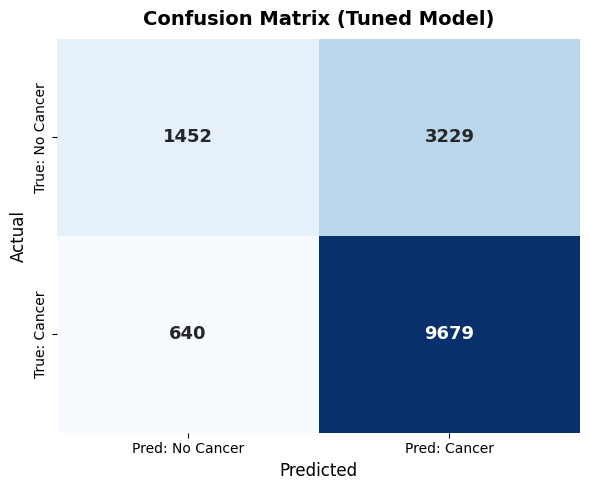

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_label, trained_pipeline.predict(test_data))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No Cancer', 'Pred: Cancer'],
            yticklabels=['True: No Cancer', 'True: Cancer'],
            cbar=False,  # remove colorbar for cleaner look
            annot_kws={"size": 13, "weight": "bold"})  # makes numbers clearer

plt.title("Confusion Matrix (Tuned Model)", fontsize=14, fontweight='bold', pad=10)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()


Generierung und Ausgabe des Classification Report

In [7]:
from sklearn.metrics import classification_report

# Vorhersagen mit deinem besten Modell
y_pred = trained_pipeline.predict(test_data)

# Bericht als Dictionary statt Text
report = classification_report(test_label, y_pred, target_names=['No Cancer (False)', 'Cancer (True)'])
print("\nClassification Report (Tuned Model):")
print(report)


Classification Report (Tuned Model):
                   precision    recall  f1-score   support

No Cancer (False)       0.69      0.31      0.43      4681
    Cancer (True)       0.75      0.94      0.83     10319

         accuracy                           0.74     15000
        macro avg       0.72      0.62      0.63     15000
     weighted avg       0.73      0.74      0.71     15000



Visualisierung mittels Validation Curve (Verhalten des F1-Scores bei steigender Anzahl an estimators)

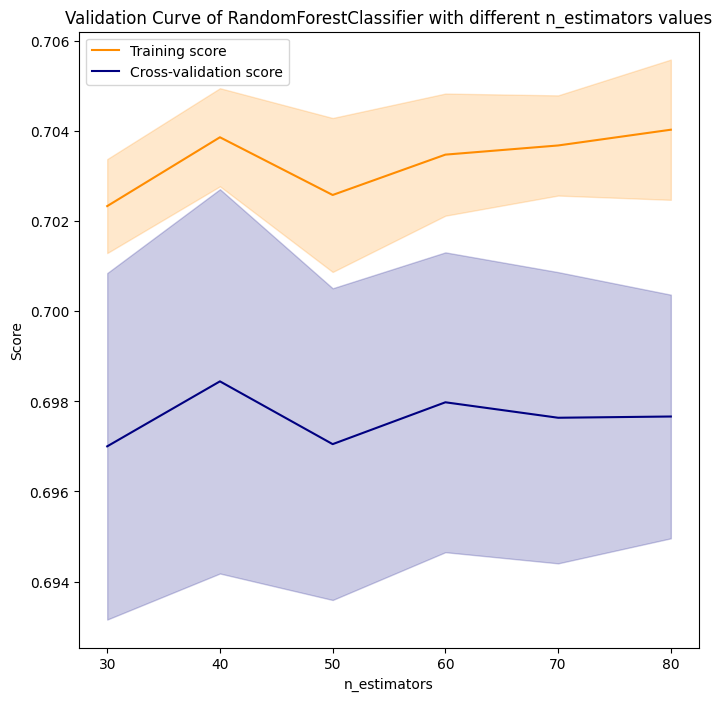

In [8]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import validation_curve
 
n_estimators = [30, 40, 50, 60, 70, 80]
 
train_scores, valid_scores = validation_curve(
    rf_pipeline,
    X=train_data,
    y=train_label,
    param_name="clf__n_estimators",
    param_range=n_estimators,
    cv=5,
    scoring=make_scorer(f1_score, average="weighted"),
    n_jobs=-1
)

# first, calculate the means and standard deviations
train_scores_mean = train_scores.mean(axis=1)  # noqa: F821
train_scores_std = train_scores.std(axis=1)  # noqa: F821
valid_scores_mean = valid_scores.mean(axis=1)  # noqa: F821
valid_scores_std = valid_scores.std(axis=1)  # noqa: F821

# create the figure
plt.figure(figsize=(8, 8))
plt.title("Validation Curve of RandomForestClassifier with different n_estimators values")
plt.xlabel("n_estimators")
plt.ylabel("Score")
# plot the training score
plt.plot(n_estimators, train_scores_mean, label="Training score", color="darkorange")  # noqa: F821
plt.fill_between(
    n_estimators,   # noqa: F821
    train_scores_mean - train_scores_std, 
    train_scores_mean + train_scores_std, 
    color="darkorange",
    alpha=0.2
)
# plot the validation score
plt.plot(n_estimators, valid_scores_mean, label="Cross-validation score", color="navy")  # noqa: F821
plt.fill_between(
    n_estimators,  # noqa: F821
    valid_scores_mean - valid_scores_std,
    valid_scores_mean + valid_scores_std,
    color="navy",
    alpha=0.2
)

plt.legend(loc="best")
plt.show()